<a href="https://colab.research.google.com/github/bori7/ML-DL-codes/blob/master/Zindi_Image1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import IPython.display as display
from PIL import Image
import os
import pathlib
from PIL import Image
from zipfile import ZipFile
import io

In [0]:
!pip install PyDrive

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1edCzgYegthJGyNaC9MMZgC0xcE8HpuGK"})   # replace the id with id of file you want to access
downloaded.GetContentFile('train_labels.csv')  

In [0]:
data = pd.read_csv('train_labels.csv')

In [0]:
data.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [0]:
downloaded1 = drive.CreateFile({'id':"1sjznOtwJJJcBKXRBpYelV5uItUN_ePeS"})   # replace the id with id of file you want to access
downloaded1.GetContentFile('images.zip') 

In [0]:
downloaded2 = drive.CreateFile({'id':"1GycRaKNWsG2Z4peWZfe1uDCMT3zQFzbE"})   # replace the id with id of file you want to access
downloaded2.GetContentFile('sample_sub_v2.csv') 

data2 = pd.read_csv('sample_sub_v2.csv')
data2.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0


In [0]:
data_dir="/content/drive/My Drive/images"
data_dir = pathlib.Path(data_dir)

In [0]:
image_count = len(list(data_dir.glob('*')))
image_count 


1817

In [0]:
frames = [data, data2]

result = pd.concat(frames)

result

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


In [0]:
#CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "'train_labels.csv"])

classy = data.target.astype(str)
result['target'] = result['target'].astype('<U1')
CLASS_NAMES  = np.array(classy.unique())
CLASS_NAMES.astype('<U1')
CLASS_NAMES

array(['0', '1'], dtype=object)

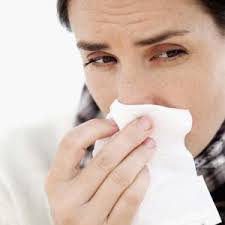

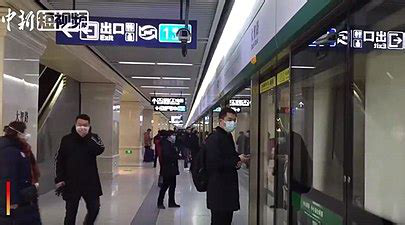

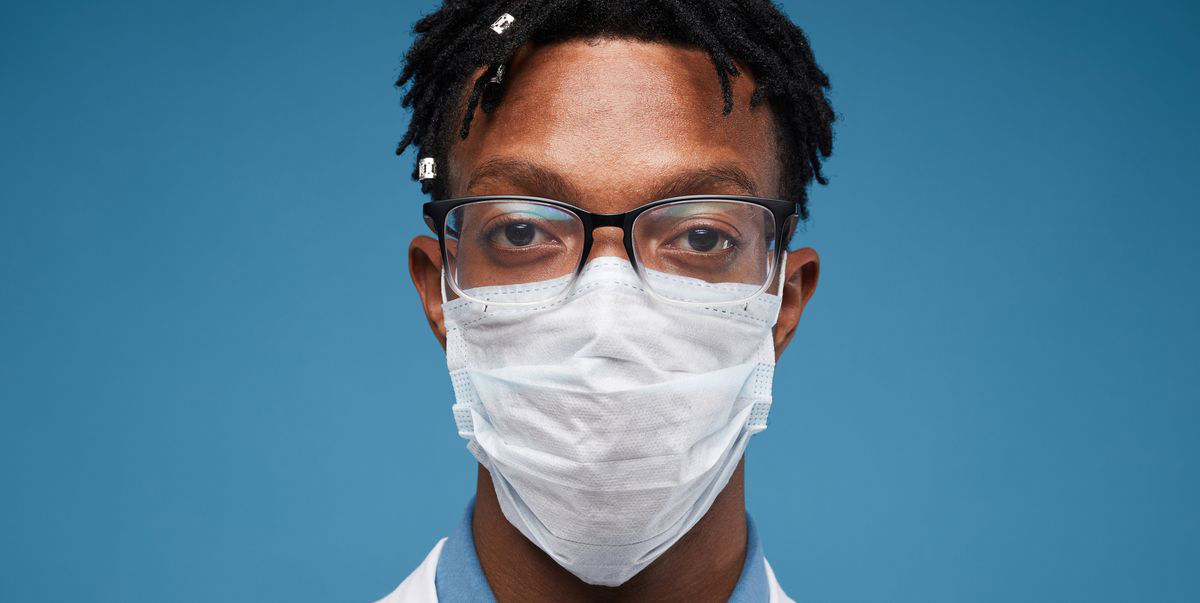

In [0]:
covid = list(data_dir.glob('*'))

for image_path in covid[:3]:
    display.display(Image.open(str(image_path)))

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'))

In [0]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/My Drive/images/znuhfdsvytafkwfjqxbzuvyaehtpex.jpg'
b'/content/drive/My Drive/images/gqbziiohphcmauvpfwlcpyxqqapghh.jpg'
b'/content/drive/My Drive/images/cvcakuzugpciyrleluofjxfnyitkpp.jpg'
b'/content/drive/My Drive/images/aqkluebfguwjhfdnbtawdmdqodyyeu.jpg'
b'/content/drive/My Drive/images/tslxepigefkmddeykwqaewrygtslwr.jpg'


In [0]:
def get_label(p):
  p = p.numpy()
  # convert the path to a list of path components
  p = tf.strings.split(p, os.path.sep)
  # The first to last is the class-directory
  pu = p[-1]
  label1 = result.loc[result['image'] == pu].target
  label1 = label1.values
  return label1  == CLASS_NAMES




In [0]:


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

  

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
#image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [0]:
'''train_data_gen = image_generator.flow_from_directory(directory=str(data_dir/'*'),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = result['target'].astype(str))'''
                                                     

"train_data_gen = image_generator.flow_from_directory(directory=str(data_dir/'*'),\n                                                     batch_size=BATCH_SIZE,\n                                                     shuffle=True,\n                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),\n                                                     classes = result['target'].astype(str))"

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


In [0]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy()

Image shape:  (224, 224, 3)
Label:  tf.Tensor(False, shape=(), dtype=bool)


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

  

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
label_batch.numpy().shape

In [0]:
image_batch.numpy().shape

In [0]:
data.shape

In [0]:
data2.shape

In [0]:
data.info

In [0]:
data['target'].unique()

In [0]:
parts = tf.strings.split(str(data_dir/'*'), os.path.sep)
parts[-1]

In [0]:
u = result.loc[result['image'] == 'klgavzoztlcdugackgmjfvkptmzaaf.jpg'].target

u = u.values
u

In [0]:
u == CLASS_NAMES
  

In [0]:
CLASS_NAMES.astype('<U1')

In [0]:
a = tf.strings.split(list_ds.take(1).numpy(), os.path.sep)

In [0]:
a = bytes.decode(a)

In [0]:
a = tf.strings.split(list_ds, os.path.sep)

In [0]:
 print("file_path: ",bytes.decode(file_path),type(bytes.decode(file_path)))

In [0]:
a = tf.strings.split(a, os.path.sep)

In [0]:
zip_path = 'images.zip'
with ZipFile(zip_path) as myzip:
    files_in_zip = myzip.namelist()

In [0]:
files_in_zip[:5]

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
File_name = mpimg.imread('/content/drive/My Drive/images/aadawlxbmapqrblgxyzarhjasgiobu.png')
plt.imshow(File_name)
plt.show()

In [0]:
from PIL import Image
image = Image.open('/content/drive/My Drive/images/aadawlxbmapqrblgxyzarhjasgiobu.png')
image.show()

In [0]:
File_name.shape

In [0]:
u = np.array(['1','2','3','4'])
u

In [0]:
parts = tf.strings.split(str(data_dir/'*'))
# The first to last is the class-directory
parts=parts.numpy()
label1 = result.loc[result['image'] == parts[-1]].target
label1 = label1.values
label1  == CLASS_NAMES

In [0]:
for p in list_ds.take(1):
  img = tf.io.read_file(p)
  p = p.numpy()
  p = tf.strings.split(p, os.path.sep)
  
pu = p[-1]
label1 = result.loc[result['image'] == pu].target
label1 = label1.values
label2 = label1  == CLASS_NAMES

img = decode_img(img)
img

In [0]:
show_batch(img.numpy(), label2.numpy())

In [0]:
label1

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224


In [0]:


for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


In [0]:
from pandas import DataFrame

boxes = {'Color': ['Green','Green','Green','Blue','Blue','Red','Red','Red'],
         'Shape': ['Rectangle','Rectangle','Square','Rectangle','Square','Square','Square','Rectangle'],
         'Price': [10,15,5,5,10,15,15,5]
        }

df = DataFrame(boxes, columns= ['Color','Shape','Price'])

select_price = df.loc[df['Color'] == 'Blue'].Price == 5
print (select_price)

In [0]:
for imagePath in imagePaths:
  image = cv2.resize(image,(32, 32)).flatten()
  data.append(image)



NameError: ignored